<h2>Метод стрельбы<h2>

Рассмотрим уравнение: $y'' = -4 \cdot y' - 4 \cdot y + 2 \cdot e^{-2x}$

Граничные условия: y(0) + y'(0) = 3; y(1) = 0

Решение: y(x) = $-2 \cdot e^{-2x} + x \cdot e^{-2x} + x^2 \cdot e^{-2x}$


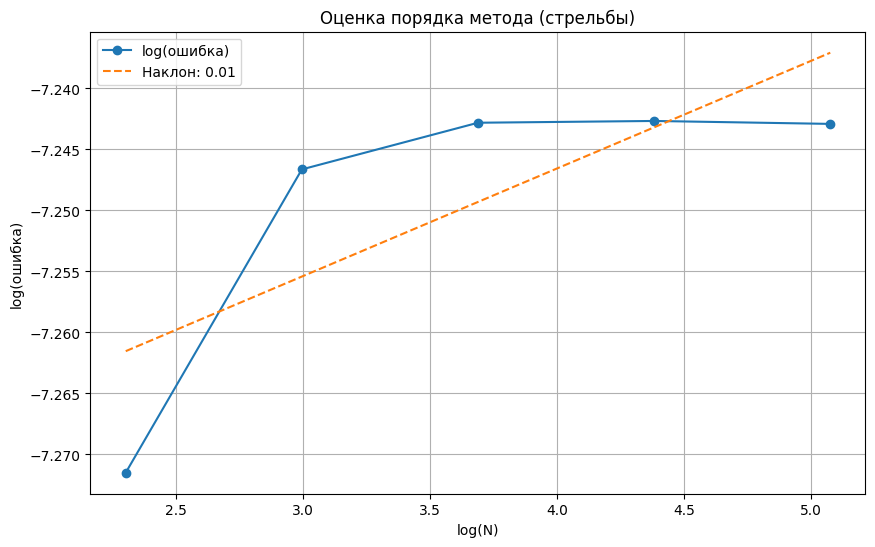

Расчетный порядок метода: 0.01


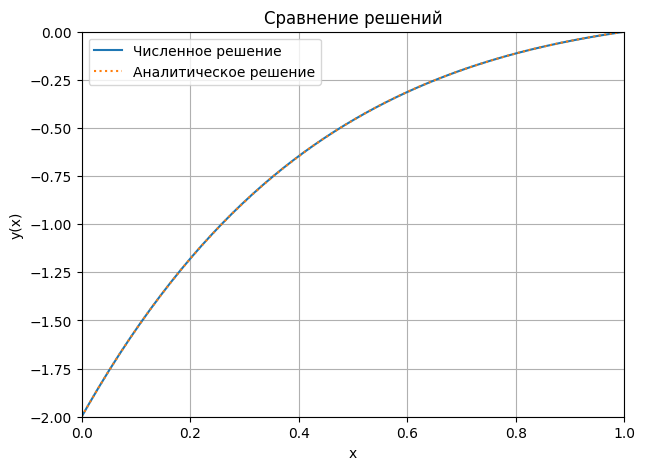

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt

# === Правая часть дифференциального уравнения ===
def f(x, y, y1):
    return -4 * y1 - 4 * y + 2 * np.exp(-2 * x)

# === Система первого порядка ===
def system(x, yz):
    y, z = yz
    return [z, f(x, y, z)]

# === Аналитическое решение ===
def analytic(x):
    return (-2 + x + x**2) * np.exp(-2 * x)

# === Метод стрельбы ===
def shooting(s, steps):
    y0 = [s, 3 - s]
    t_eval = np.linspace(0, 1, steps)
    return solve_ivp(system, [0, 1], y0, method='RK45', t_eval=t_eval)

# === Оценка порядка сходимости ===
def calculate_order():
    steps_array = np.array([10, 20, 40, 80, 160])
    errors = []

    # Начальная оценка для стрельбы
    phi1 = shooting(s1, steps_array[0]).y[0][-1]
    phi2 = shooting(s2, steps_array[0]).y[0][-1]
    s3 = s1 + (0 - phi1) * (s2 - s1) / (phi2 - phi1)

    for steps in steps_array:
        sol = shooting(s3, steps)
        y_exact = analytic(sol.t)
        error = np.max(np.abs(y_exact - sol.y[0]))
        errors.append(error)

    # Построение графика log-log
    log_steps = np.log(steps_array)
    log_errors = np.log(errors)
    slope, intercept, *_ = linregress(log_steps, log_errors)

    plt.figure(figsize=(10, 6))
    plt.plot(log_steps, log_errors, 'o-', label='log(ошибка)')
    plt.plot(log_steps, slope * log_steps + intercept, '--', label=f'Наклон: {slope:.2f}')
    plt.xlabel('log(N)')
    plt.ylabel('log(ошибка)')
    plt.title('Оценка порядка метода (стрельбы)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return slope

# === Основной блок ===
if __name__ == "__main__":
    s1, s2 = 0, 1
    order = calculate_order()
    print(f"Расчетный порядок метода: {order:.2f}")

    # Уточнённое значение начального условия
    phi1 = shooting(s1, 160).y[0][-1]
    phi2 = shooting(s2, 160).y[0][-1]
    s3 = s1 + (0 - phi1) * (s2 - s1) / (phi2 - phi1)
    sol = shooting(s3, 160)

    x_vals = np.linspace(0, 1, 160)
    y_exact = analytic(x_vals)

    # График численного и аналитического решения
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(sol.t, sol.y[0], label='Численное решение')
    plt.plot(x_vals, y_exact, linestyle=':', label='Аналитическое решение')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.title('Сравнение решений')
    plt.xlim(0, 1)
    plt.ylim(-2, 0)
    plt.legend()
    plt.grid(True)
    plt.show()


<h2>Метод конечных разностей<h2>

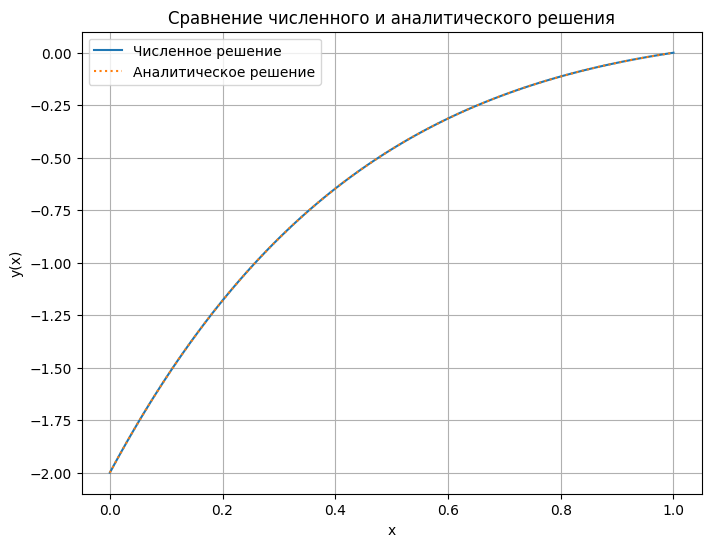

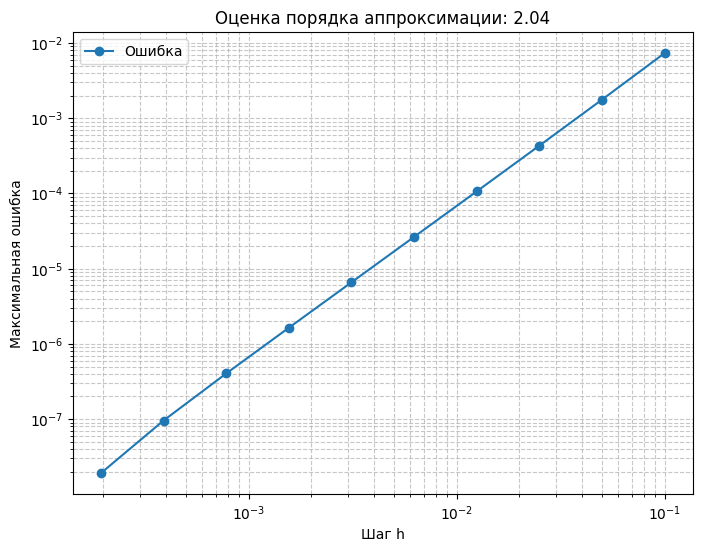

Оцененный порядок метода: 2.04


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# === Точное решение ===
def analytic(x):
    return (-2 + x + x**2) * np.exp(-2 * x)

# === Решение методом конечных разностей ===
def solve_finite_difference(N):
    h = 1 / N
    x = np.linspace(0, 1, N + 1)

    A = np.zeros((N + 1, N + 1))
    b = np.zeros(N + 1)

    # Внутренние узлы
    for i in range(1, N):
        A[i, i - 1] = 1 / h**2 - 2 / h
        A[i, i]     = -2 / h**2 + 4
        A[i, i + 1] = 1 / h**2 + 2 / h
        b[i] = 2 * np.exp(-2 * x[i])

    # Левый граничный узел: производная
    A[0, 0] = -3 / (2 * h) + 1
    A[0, 1] = 4 / (2 * h)
    A[0, 2] = -1 / (2 * h)
    b[0] = 3

    # Правый граничный узел: значение
    A[N, N] = 1
    b[N] = 0

    y = np.linalg.solve(A, b)
    return x, y

# === Построение графика решения ===
def plot_solution(N=100):
    x, y_numeric = solve_finite_difference(N)
    x_analytic = np.linspace(0, 1, 1000)
    y_analytic = analytic(x_analytic)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y_numeric, '-', label="Численное решение", markersize=4)
    plt.plot(x_analytic, y_analytic, linestyle=":", label="Аналитическое решение")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Сравнение численного и аналитического решения")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Оценка порядка сходимости ===
def estimate_order():
    N_values = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
    h_values = [1 / N for N in N_values]
    errors = []

    # Эталонное решение на самой плотной сетке
    x_ref, y_ref = solve_finite_difference(N_values[-1])

    for N in N_values[:-1]:
        x, y = solve_finite_difference(N)
        y_interp = np.interp(x, x_ref, y_ref)
        error = np.linalg.norm(y - y_interp, ord=np.inf)
        errors.append(error)

    # Аппроксимация наклона на log-log графике
    log_h = np.log(h_values[:-1])
    log_err = np.log(errors)
    p = np.polyfit(log_h, log_err, 1)[0]

    # График ошибки
    plt.figure(figsize=(8, 6))
    plt.loglog(h_values[:-1], errors, '-o', label="Ошибка")
    plt.xlabel("Шаг h")
    plt.ylabel("Максимальная ошибка")
    plt.title(f"Оценка порядка аппроксимации: {p:.2f}")
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    print(f"Оцененный порядок метода: {p:.2f}")

# === Основной блок ===
if __name__ == "__main__":
    plot_solution(N=100)
    estimate_order()


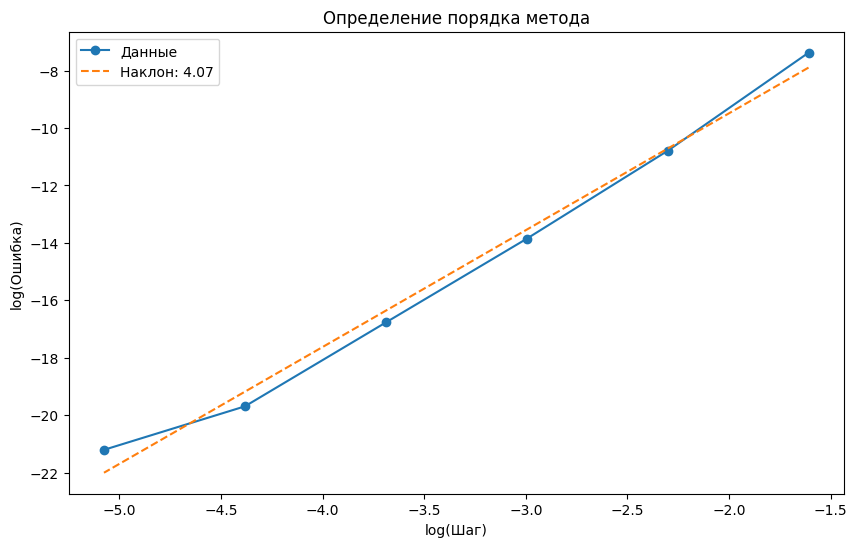

Расчетный порядок метода: 4.07


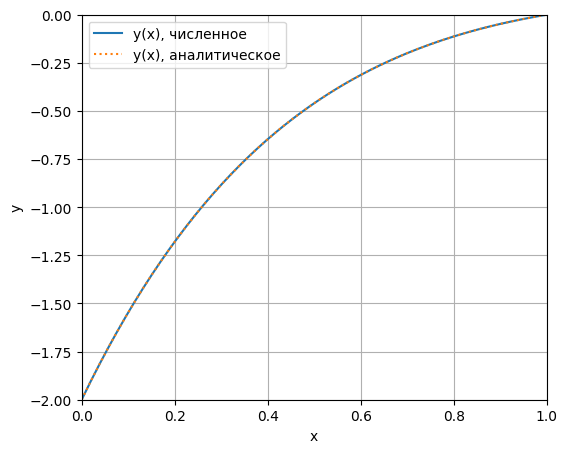

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def f(x, y, y1):
    return -4 * y1 - 4 * y + 2 * np.exp(-2 * x)

def system(x, yz):
    y, z = yz
    dydx = z
    dzdx = f(x, y, z)
    return np.array([dydx, dzdx])

def rk4(func, x_range, yz0, step):
    x_vals = np.linspace(x_range[0], x_range[1], step)
    h = x_vals[1] - x_vals[0]
    yz = np.array(yz0)
    y_vals = [yz[0]]

    for x in x_vals[:-1]:
        k1 = func(x, yz)
        k2 = func(x + h / 2, yz + h * k1 / 2)
        k3 = func(x + h / 2, yz + h * k2 / 2)
        k4 = func(x + h, yz + h * k3)
        yz = yz + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y_vals.append(yz[0])

    return np.array(x_vals), np.array(y_vals)

def analytic(x):
    return -2 * np.exp(-2 * x) + x * np.exp(-2 * x) + (x ** 2) * np.exp(-2 * x)

def shooting(s, step):
    x_vals, y_vals = rk4(system, [0, 1], [s, 3 - s], step)
    return x_vals, y_vals

def find_s3_newton(tol=1e-10, max_iter=20): #Метод Ньютона
    s = 0 
    for _ in range(max_iter):
        _, y1 = shooting(s, 160)
        f_s = y1[-1] 
        if abs(f_s) < tol:
            return s 

        _, y1_plus = shooting(s + 1e-6, 160)
        df_ds = (y1_plus[-1] - y1[-1]) / 1e-6 

        s -= f_s / df_ds 

    print("Метод Ньютона не сходится")
    return s

def calculate_order():
    steps = np.array([5, 10, 20, 40, 80, 160])
    errors = []

    s3 = find_s3_newton()

    for step in steps:
        x_vals, y_num = shooting(s3, step)
        y_exact = analytic(x_vals)
        error = np.max(np.abs(y_exact - y_num))
        errors.append(error)
    
    log_steps = np.log(1/steps)
    log_errors = np.log(errors)
    coeffs = linregress(log_steps, log_errors)

    plt.figure(figsize=(10, 6))
    plt.plot(log_steps, log_errors, 'o-', label='Данные')
    plt.plot(log_steps, coeffs[0] * log_steps + coeffs[1], '--', label=f'Наклон: {coeffs[0]:.2f}')
    plt.xlabel('log(Шаг)')
    plt.ylabel('log(Ошибка)')
    plt.legend()
    plt.title('Определение порядка метода')
    plt.show()
    
    return coeffs[0]

order = calculate_order()
print(f"Расчетный порядок метода: {order:.2f}")

s3 = find_s3_newton()
x_vals, y_vals = shooting(s3, 160)

X = np.linspace(0, 1, 160)
Y = analytic(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)
ax.plot(x_vals, y_vals, label='y(x), численное')
ax.plot(X, Y, linestyle=":", label='y(x), аналитическое')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0, 1)
ax.set_ylim(-2, 0)
ax.legend()
ax.grid()
plt.show()